In [1]:
import pandas as pd
import draft.data_cleaning as dc

In [2]:
person_0 = pd.read_json(r'datasets/december/liza.json', orient='records', lines=True) # liza
person_1 = pd.read_json(r'datasets/december/sleep_data_Adham.json', lines=True) # adham
person_2 = pd.read_json(r'datasets/december/sleep_data_Miriam.json', lines=True) # miriam
person_3 = pd.read_json(r'datasets/december/sleep_data_Syahid.json', lines=True) # syahid
person_4 = pd.read_json(r'datasets/december/sleep_data_Florian.json', lines=True) # florian
person_5 = pd.read_json(r'datasets/december/sleep_data_Shado.json', lines=True) # shado
person_6 = pd.read_json(r'datasets/december/sleep_data_Alina.json', lines=True) # alina

# labels dataframe from excel
labels_df = pd.read_excel(r'datasets\sleep_data.xlsx', sheet_name=None) # dict of all label|

In [3]:
people_df = [person_0, person_1, person_2, person_3, person_4, person_5, person_6]

for num, df in enumerate(people_df):
    df.insert(0, "temp_id", num)

[embeddings + static data] + label --> RF (Leute mit Label)

In [4]:
def get_static_data(df):
    # Extract temp_id
    temp_id = df['temp_id']

    # static data from dailySleepDTO json
    sleepDTO_df = pd.json_normalize(df['dailySleepDTO'])

    cols_to_keep = ['id', 'calendarDate', 'sleepTimeSeconds', 'sleepStartTimestampLocal',
       'sleepEndTimestampLocal', 'deepSleepSeconds', 'lightSleepSeconds',
       'remSleepSeconds', 'awakeSleepSeconds', 'averageRespirationValue',
       'lowestRespirationValue', 'highestRespirationValue', 'awakeCount',
       'avgSleepStress', 'ageGroup', 'sleepVersion',
       'sleepScores.totalDuration.qualifierKey',
       'sleepScores.stress.qualifierKey',
       'sleepScores.awakeCount.qualifierKey', 'sleepScores.overall.value',
       'sleepScores.remPercentage.value',
       'sleepScores.remPercentage.idealStartInSeconds',
       'sleepScores.remPercentage.idealEndInSeconds',
       'sleepScores.restlessness.qualifierKey',
       'sleepScores.lightPercentage.value',
       'sleepScores.lightPercentage.idealStartInSeconds',
       'sleepScores.lightPercentage.idealEndInSeconds',
       'sleepScores.deepPercentage.value',
       'sleepScores.deepPercentage.idealStartInSeconds',
       'sleepScores.deepPercentage.idealEndInSeconds']
    
    sleepDTO_df = sleepDTO_df[cols_to_keep]

    # Add temp_id to the sleepDTO_df
    sleepDTO_df['temp_id'] = temp_id 

    # change the time format
    sleepDTO_df['sleepStartTimestampLocal'] = pd.to_datetime(sleepDTO_df['sleepStartTimestampLocal'], unit='ms')
    sleepDTO_df['sleepEndTimestampLocal'] = pd.to_datetime(sleepDTO_df['sleepEndTimestampLocal'], unit='ms')

    return sleepDTO_df

In [5]:
def combine_static_data(df):
    # Process the sleepDTO data
    sleepDTO = get_static_data(df)

    # Extract the required static values from the original DataFrame
    cols = ['temp_id', 'remSleepData', 'restlessMomentsCount', 'avgOvernightHrv', 'restingHeartRate']
    static_values = df[cols]

    # Set 'temp_id' as the index for both DataFrames
    static_values.set_index('temp_id', inplace=True)
    sleepDTO.set_index('temp_id', inplace=True)

    # Concatenate static_values and sleepDTO horizontally
    combined_data = pd.concat([sleepDTO, static_values], axis=1)

    # Reset the index if you want 'temp_id' back as a column
    combined_data.reset_index(inplace=True)

    return combined_data

In [6]:
def process_dataframe(dataframe):
    for col in dataframe.columns:
        if col.endswith("qualifierKey"):
            new_name = col.replace("qualifierKey", "value")
            dataframe[new_name] = dataframe[col].apply(dc.convert_num)
            dataframe.drop(col, axis=1, inplace=True)
    
    return dataframe

sleepDTO --> drop irrelavnt columns --> change qualifier key to integer
static values 
labels

In [7]:
people_dict = {0: 'Liza', 1: 'Adham', 2: 'Miriam', 3: 'Syahid', 4: 'Florian', 5: 'Shado', 6: 'Alina'} # excel

persons_static_data = {
    0 : person_0,
    1 : person_1,
    2 : person_2,
    3 : person_3,
    4 : person_4,
    5 : person_5,
    6 : person_6
}

def process_all_people(persons_static_data): # we put persons_data as the argument
    processed_people = {}

    for person_id, person_df in persons_static_data.items():
        # Clean the data for each person
        cleaned_df = dc.delete_untracked_nights(person_df)

        # Combine the static data
        combined_df = combine_static_data(cleaned_df)

        # Process the DataFrame to change 'qualifierKey' to numerical value
        final_processed_df = process_dataframe(combined_df)

        # Load the embeddings DataFrame from a pickle file according to person id
        embeddings_file_name = f"datasets/embeddings_100/embeddings_{person_id}.pkl"
        embeddings_df = pd.read_pickle(embeddings_file_name)

        # combine the static and the embeddings
        combined_df_with_embeddings = pd.concat([final_processed_df, embeddings_df], axis=1)

        # Store the processed DataFrame in the dictionary with the same person_id
        processed_people[person_id] = combined_df_with_embeddings

    return processed_people

In [8]:
all_df = process_all_people(persons_static_data)

In [9]:
all_df[0] # data from liza

,temp_id,id,calendarDate,sleepTimeSeconds,sleepStartTimestampLocal,sleepEndTimestampLocal,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,0,1701986940000,2023-12-08,36780,2023-12-07 23:09:00,2023-12-08 09:34:00,3780,27000,6000,720,...,0.0,1.294890,1.599485,1.008841,1.276859,0.000000,0.0,0.000000,0.131409,0.0
1,0,1702078860000,2023-12-09,29940,2023-12-09 00:41:00,2023-12-09 09:42:00,3240,24480,2220,2520,...,0.0,2.403386,2.422224,1.581123,0.029759,0.000000,0.0,0.000000,0.350698,0.0
2,0,1702171920000,2023-12-10,25080,2023-12-10 02:32:00,2023-12-10 09:39:00,2040,17580,5460,540,...,0.0,1.174797,2.238895,2.448936,0.778737,0.000000,0.0,0.000000,0.000000,0.0
3,0,1702254240000,2023-12-11,21420,2023-12-11 01:24:00,2023-12-11 07:22:00,3720,15000,2700,60,...,0.0,0.544954,2.681309,1.326715,0.034641,0.362635,0.0,0.000000,0.000000,0.0
4,0,1702340700000,2023-12-12,31080,2023-12-12 01:25:00,2023-12-12 10:04:00,6540,17520,7020,60,...,0.0,0.630449,1.376675,2.312008,1.645187,0.000000,0.0,0.000000,0.000000,0.0
5,0,1702510140000,2023-12-14,23880,2023-12-14 00:29:00,2023-12-14 07:21:00,5280,15600,3000,840,...,0.0,1.339422,2.192270,1.335280,0.000000,0.549342,0.0,0.455504,0.000000,0.0
6,0,1702596000000,2023-12-15,32100,2023-12-15 00:20:00,2023-12-15 09:27:00,3540,23520,5040,720,...,0.0,1.175953,0.543134,2.698443,0.960822,0.000000,0.0,0.000000,0.000000,0.0
7,0,1702680600000,2023-12-16,38040,2023-12-15 23:50:00,2023-12-16 10:56:00,4500,22380,11160,1920,...,0.0,0.734908,0.199487,1.495331,0.930846,0.000000,0.0,0.000000,0.000000,0.0
8,0,1702777020000,2023-12-17,25260,2023-12-17 02:37:00,2023-12-17 09:44:00,3780,18000,3480,360,...,0.0,0.878956,1.722102,2.497085,0.465217,0.000000,0.0,0.321693,0.000000,0.0
9,0,1702858680000,2023-12-18,30176,2023-12-18 01:18:00,2023-12-18 09:59:56,3000,22740,4380,1140,...,0.0,0.541869,2.074739,2.222410,1.690510,0.000000,0.0,0.090637,0.000000,0.0


In [10]:
def merge_with_labels(persons_data, labels_df, people_dict):
    merged_data = {}

    for person_id, person_df in persons_data.items():
        # Check if 'calendarDate' exists in person_df
        if 'calendarDate' not in person_df.columns:
            print(f"'calendarDate' column not found in person data for {person_id}")
            continue

        # Get the label DataFrame for the current person
        person_label_df = labels_df[people_dict[person_id]]

        # Ensure the date columns are in the same format
        person_df['calendarDate'] = pd.to_datetime(person_df['calendarDate'])
        person_label_df['Datum'] = pd.to_datetime(person_label_df['Datum'])

        # Merge the person's data with their labels on the date
        merged_df = pd.merge(person_df, person_label_df, left_on='calendarDate', right_on='Datum')

        # Store the merged DataFrame in the dictionary with the same person_id
        merged_data[person_id] = merged_df

    return merged_data

# Example usage
merged_people_data = merge_with_labels(all_df, labels_df, people_dict)

In [11]:
# person 0 --> 4 NaN entries --> test label
# person 4 --> 8 NaN entries --> 4 columns can subtitute as '3'. Remaining is test label.
# person 6 --> 2 NaN entriies --> can subtitute as '3' (wach, konzentriert)

merged_people_data[6].isna().any().value_counts()

False    144
Name: count, dtype: int64

In [12]:
merged_people_data[4]

,temp_id,id,calendarDate,sleepTimeSeconds,sleepStartTimestampLocal,sleepEndTimestampLocal,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,...,embedding_99,Datum,ausgeschlafen,motivation,konzentriert,Wach,Test_zeit,Test_anzahl,prozent_zeit_rang,prozent_anzahl
0,4,1701988440000,2023-12-08,22800,2023-12-07 23:34:00,2023-12-08 06:21:00,2640,16980,3180,1620,...,0.0,2023-12-08,3,3,4,2,NaN,NaN,NaN,NaN
1,4,1702067940000,2023-12-09,35460,2023-12-08 21:39:00,2023-12-09 09:08:00,4620,23580,7260,5880,...,0.0,2023-12-09,4,1,3,2,NaN,NaN,NaN,NaN
2,4,1702169940000,2023-12-10,26220,2023-12-10 01:59:00,2023-12-10 09:29:00,2820,18300,5100,780,...,0.0,2023-12-10,2,2,2,3,60.00,93.0,2.0,62.0
3,4,1702246860000,2023-12-11,24780,2023-12-10 23:21:00,2023-12-11 06:16:00,3420,14520,6840,120,...,0.0,2023-12-11,2,3,3,3,61.33,93.0,3.0,62.0
4,4,1702334760000,2023-12-12,23460,2023-12-11 23:46:00,2023-12-12 06:45:00,5040,14100,4320,1680,...,0.0,2023-12-12,3,3,4,2,60.00,92.0,2.0,56.0
5,4,1702421040000,2023-12-13,23760,2023-12-12 23:44:00,2023-12-13 06:30:00,2460,15360,5940,600,...,0.0,2023-12-13,2,2,4,3,63.67,97.0,4.0,81.0
6,4,1702506960000,2023-12-14,22740,2023-12-13 23:36:00,2023-12-14 06:32:00,3120,14040,5580,2220,...,0.0,2023-12-14,3,3,4,3,51.67,97.0,0.0,81.0
7,4,1702677060000,2023-12-16,37140,2023-12-15 22:51:00,2023-12-16 09:36:00,7680,17940,11520,1560,...,0.0,2023-12-16,4,3,4,2,51.67,93.0,0.0,62.0
8,4,1702772280000,2023-12-17,28920,2023-12-17 01:18:00,2023-12-17 09:40:00,3960,19620,5340,1200,...,0.0,2023-12-17,4,5,4,3,55.67,99.0,1.0,87.0
9,4,1702853220000,2023-12-18,23460,2023-12-17 23:47:00,2023-12-18 06:24:00,5940,14100,3420,360,...,0.0,2023-12-18,3,3,5,4,61.33,97.0,3.0,81.0


In [13]:
data = pd.DataFrame()
# combine all data of all people
for df in merged_people_data.values():
    #print(df.shape)
    data = pd.concat([data, df])

data.drop('Datum', axis='columns', inplace=True)
data

,temp_id,id,calendarDate,sleepTimeSeconds,sleepStartTimestampLocal,sleepEndTimestampLocal,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,...,embedding_98,embedding_99,ausgeschlafen,motivation,konzentriert,Wach,Test_zeit,Test_anzahl,prozent_zeit_rang,prozent_anzahl
0,0,1701986940000,2023-12-08,36780,2023-12-07 23:09:00,2023-12-08 09:34:00,3780,27000,6000,720,...,0.131409,0.0,4,3,4,2,NaN,NaN,NaN,NaN
1,0,1702078860000,2023-12-09,29940,2023-12-09 00:41:00,2023-12-09 09:42:00,3240,24480,2220,2520,...,0.350698,0.0,5,5,4,4,80.33,71.0,32.0,6.0
2,0,1702171920000,2023-12-10,25080,2023-12-10 02:32:00,2023-12-10 09:39:00,2040,17580,5460,540,...,0.000000,0.0,4,2,3,2,79.33,27.0,33.0,7.0
3,0,1702254240000,2023-12-11,21420,2023-12-11 01:24:00,2023-12-11 07:22:00,3720,15000,2700,60,...,0.000000,0.0,4,4,5,3,100.00,87.0,61.0,28.0
4,0,1702340700000,2023-12-12,31080,2023-12-12 01:25:00,2023-12-12 10:04:00,6540,17520,7020,60,...,0.000000,0.0,5,5,4,2,85.00,81.0,32.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,6,1702856640000,2023-12-18,22620,2023-12-18 00:44:00,2023-12-18 07:11:00,2940,15720,3960,600,...,0.000000,0.0,3,3,3,3,51.00,97.0,0.0,81.0
6,6,1702940220000,2023-12-19,25800,2023-12-18 23:57:00,2023-12-19 07:10:00,2640,15420,7740,180,...,0.000000,0.0,3,3,4,3,47.70,93.0,0.0,62.0
7,6,1703028000000,2023-12-20,26520,2023-12-20 00:20:00,2023-12-20 07:59:00,3420,15120,7980,1020,...,0.000000,0.0,4,4,3,3,44.33,88.0,0.0,33.0
8,6,1703113800000,2023-12-21,28320,2023-12-21 00:10:00,2023-12-21 08:07:00,1200,19860,7260,300,...,0.000000,0.0,5,5,3,3,44.70,95.0,0.0,72.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 9
Columns: 143 entries, temp_id to prozent_anzahl
dtypes: datetime64[ns](3), float32(100), float64(18), int64(21), object(1)
memory usage: 55.8+ KB


In [20]:
data.isna().any().value_counts()

False    2039
True        4
Name: count, dtype: int64

### data without high correlated features

In [24]:
cols_to_remove = ['awakeCount', 'lowestRespirationValue', 'highestRespirationValue',
                  'sleepScores.remPercentage.idealStartInSeconds', 'sleepScores.remPercentage.idealEndInSeconds', 'sleepScores.lightPercentage.idealStartInSeconds',
                  'sleepScores.lightPercentage.idealEndInSeconds', 'sleepScores.deepPercentage.idealStartInSeconds', 'sleepScores.deepPercentage.idealEndInSeconds',
                  'sleepScores.remPercentage.value', 'sleepScores.lightPercentage.value', 'sleepScores.deepPercentage.value', 
                  'sleepVersion', 'remSleepData',
                  'sleepScores.totalDuration.value', 'sleepScores.stress.value', 'sleepScores.awakeCount.value', 'sleepScores.restlessness.value']

data_filtered = data.drop(cols_to_remove, axis='columns')

In [25]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

data_copy = data_filtered.copy().dropna()

# list of columns that need to be dropped
to_drop = ['temp_id', 'id', 'calendarDate', 'ageGroup',
            'ausgeschlafen', 'motivation', 'Wach', 'konzentriert',
            'Test_zeit', 'Test_anzahl','prozent_zeit_rang', 'prozent_anzahl'] 

# train with the suitable dataset
features = data_copy.drop(to_drop, axis=1)  # Drop the target variable to isolate the features
target = data_copy['prozent_zeit_rang'].to_numpy()  # Isolate the target variable

# Convert Timestamp to Unix format
features['sleepStartTimestampLocal'] = features['sleepStartTimestampLocal'].astype('int64') // 10**9
 
features['sleepEndTimestampLocal'] = features['sleepEndTimestampLocal'].astype('int64') // 10**9
 
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# normalize the features values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train size : {X_train.shape}, y_train size : {y_train.shape}\nX_test size : {X_test.shape}, y_test size : {y_test.shape}")


X_train size : (57, 113), y_train size : (57,)
X_test size : (15, 113), y_test size : (15,)


In [14]:
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

parameters = {"n_estimators" : [20, 40, 60, 80],
              "max_depth": [5, 8, 10, 12, 15],
              "min_samples_leaf": [2, 4, 6, 8, 10],
              "n_estimators":[10, 50, 100]}
 
random_search = RandomizedSearchCV(rf_regressor, parameters, n_iter=20, verbose=2)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=6, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=12, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=12, min_samples_leaf=2, n_estimators=10; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=4, n_estimators=100; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=4, n_e

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), n_iter=20,
                   param_distributions={'max_depth': [5, 8, 10, 12, 15],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 50, 100]},
                   verbose=2)

In [15]:
best_model = random_search.best_estimator_
# Train the regressor
best_model.fit(X_train, y_train)
 
# Make predictions on the test set
y_pred = best_model.predict(X_test)
 
# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
 
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 134.93741832857822
R-squared: 0.1491727630330092


In [16]:
y_pred

array([10.26947685, 13.4105244 , 25.93910965, 24.53630781, 11.37201302,
        7.93535895, 23.83188268, 10.50650226,  9.04772489,  6.23208642,
       10.88168037, 13.90187742, 10.15563693, 25.23899514, 14.78976551])

In [17]:
y_test

array([18.,  5., 37., 32.,  3.,  0.,  7.,  2.,  7.,  0.,  3.,  3., 16.,
        0., 33.])

## Classication

In [24]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

data_copy = data.copy().dropna()

# list of columns that need to be dropped
to_drop = ['temp_id', 'id', 'calendarDate', 'ageGroup',
            'ausgeschlafen', 'motivation', 'Wach', 'konzentriert',
            'Test_zeit', 'Test_anzahl','prozent_zeit_rang', 'prozent_anzahl'] 

# train with the suitable dataset
features = data_copy.drop(to_drop, axis=1)  # Drop the target variable to isolate the features
target = pd.get_dummies(data_copy['konzentriert'], dtype=int).to_numpy()  # Isolate the target variable

# Convert Timestamp to Unix format
features['sleepStartTimestampLocal'] = features['sleepStartTimestampLocal'].astype('int64') // 10**9
 
features['sleepEndTimestampLocal'] = features['sleepEndTimestampLocal'].astype('int64') // 10**9

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# normalize the features values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
 
# Initialize the Random Forest Regressor
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')

parameters = {"n_estimators" : [20, 40, 60, 80],
              "max_depth": [5, 8, 10, 12, 15],
              "min_samples_leaf": [2, 4, 6, 8, 10],
              "n_estimators":[10, 50, 100]}
 
random_search = RandomizedSearchCV(rf_classifier, parameters, n_iter=20, verbose=2)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .max_depth=10, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=10, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END .max_depth=12, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END .max_depth=12, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=12, min_samples_leaf=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=10, n_

RandomizedSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                                    random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [5, 8, 10, 12, 15],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 50, 100]},
                   verbose=2)

In [25]:
from sklearn.metrics import accuracy_score #recall_score, classification_report
best_model = random_search.best_estimator_

# Train the classifier
best_model.fit(X_train, y_train)
 
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report for more detailed performance analysis
#print(classification_report(y_test, y_pred))

Accuracy: 20.00%


In [72]:
y_pred

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [73]:
y_test

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

### classification without one-hot-encoding

In [40]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

data_copy = data.copy().dropna()

# list of columns that need to be dropped
to_drop = ['temp_id', 'id', 'calendarDate', 'ageGroup',
            'ausgeschlafen', 'motivation', 'Wach', 'konzentriert',
            'Test_zeit', 'Test_anzahl','prozent_zeit_rang', 'prozent_anzahl'] 

# train with the suitable dataset
features = data_copy.drop(to_drop, axis=1)  # Drop the target variable to isolate the features
target = data_copy['konzentriert'].to_numpy() # Isolate the target variable

# Convert Timestamp to Unix format
features['sleepStartTimestampLocal'] = features['sleepStartTimestampLocal'].astype('int64') // 10**9
 
features['sleepEndTimestampLocal'] = features['sleepEndTimestampLocal'].astype('int64') // 10**9

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# normalize the features values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
 
# Initialize the Random Forest Regressor
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, criterion = 'entropy')

parameters = {"n_estimators" : [20, 40, 60, 80],
              "max_depth": [5, 8, 10, 12, 15],
              "min_samples_leaf": [2, 4, 6, 8, 10],
              "n_estimators":[10, 50, 100]}
 
random_search = RandomizedSearchCV(rf_classifier, parameters, n_iter=20, verbose=2)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..max_depth=15, min_samples_leaf=4, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=4, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=4, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=4, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=15, min_samples_leaf=4, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=6, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=10, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=10, n_

RandomizedSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                                    random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [5, 8, 10, 12, 15],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 50, 100]},
                   verbose=2)

In [41]:
from sklearn.metrics import accuracy_score #recall_score, classification_report
best_model = random_search.best_estimator_

# Train the classifier
best_model.fit(X_train, y_train)
 
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate accuracy
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse * 100:.2f}%")

Accuracy: 40.00%
MSE: 120.00%


In [58]:
y_test

array([3, 4, 4, 4, 3, 5, 5, 2, 4, 5, 5, 3, 2, 4, 4], dtype=int64)

In [59]:
y_pred

array([3, 3, 3, 3, 5, 3, 3, 3, 4, 5, 3, 3, 4, 3, 3], dtype=int64)

In [45]:
# Make predictions on the test set
y_pred = best_model.predict_proba(X_test)

In [46]:
y_pred

array([[0.10572791, 0.48246428, 0.2335502 , 0.17825761],
       [0.07224677, 0.3514286 , 0.30375525, 0.27256938],
       [0.15071635, 0.49081012, 0.18137878, 0.17709476],
       [0.11587354, 0.54590472, 0.14303349, 0.19518824],
       [0.04290678, 0.32439333, 0.30033729, 0.3323626 ],
       [0.14022909, 0.42521506, 0.23071845, 0.2038374 ],
       [0.11765121, 0.3657097 , 0.3229408 , 0.19369828],
       [0.1128206 , 0.42118815, 0.3651669 , 0.10082435],
       [0.09605275, 0.35285308, 0.37479301, 0.17630116],
       [0.08584706, 0.30973843, 0.26744864, 0.33696587],
       [0.10403466, 0.45282388, 0.2960403 , 0.14710115],
       [0.09941257, 0.45683357, 0.28787027, 0.1558836 ],
       [0.03426357, 0.30907925, 0.47761885, 0.17903833],
       [0.08640464, 0.41835308, 0.2803419 , 0.21490038],
       [0.16844648, 0.35952592, 0.28415913, 0.18786847]])

In [47]:
y_test

5     3
0     4
5     4
1     4
3     3
1     5
11    5
9     2
13    4
5     5
9     5
6     3
10    2
7     4
6     4
Name: konzentriert, dtype: int64

Classification without One-Hot Encoding - oversampling

In [36]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

data_copy = data_filtered.copy().dropna()

# list of columns that need to be dropped
to_drop = ['temp_id', 'id', 'calendarDate', 'ageGroup',
            'ausgeschlafen', 'motivation', 'Wach', 'konzentriert',
            'Test_zeit', 'Test_anzahl','prozent_zeit_rang', 'prozent_anzahl'] 

# train with the suitable dataset
features = data_copy.drop(to_drop, axis=1)  # Drop the target variable to isolate the features
target = data_copy['konzentriert']#.to_numpy() # Isolate the target variable

# Convert Timestamp to Unix format
features['sleepStartTimestampLocal'] = features['sleepStartTimestampLocal'].astype('int64') // 10**9
 
features['sleepEndTimestampLocal'] = features['sleepEndTimestampLocal'].astype('int64') // 10**9

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# normalize the features values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train size : {X_train.shape}\ny_train size : {y_train.shape}")

X_train size : (57, 113)
y_train size : (57,)


In [37]:
from imblearn.over_sampling import RandomOverSampler

# Instantiate the RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='not majority')
# Fit the resampling method to the training data
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

print(f"X_train_resampled size : {X_resampled.shape}\ny_train_resampled size : {y_resampled.shape}")

X_train_resampled size : (84, 113)
y_train_resampled size : (84,)


In [38]:
X_resampled

array([[ 0.33173872,  1.00738623,  1.01218591, ..., -0.41883788,
        -0.2652718 ,  0.        ],
       [ 0.57144445,  0.26190291,  0.29028154, ..., -0.41883788,
        -0.2652718 ,  0.        ],
       [ 0.58103268, -1.34526191, -1.3336392 , ..., -0.41883788,
        -0.2652718 ,  0.        ],
       ...,
       [-0.76131943,  1.46666878,  1.45202812, ..., -0.38985427,
        -0.2652718 ,  0.        ],
       [ 0.09203298, -0.64547995, -0.63277216, ..., -0.41883788,
        -0.2652718 ,  0.        ],
       [ 1.012503  ,  0.07131847,  0.09463429, ..., -0.41883788,
        -0.2652718 ,  0.        ]])

In [39]:
y_resampled.value_counts()

konzentriert
4    21
5    21
2    21
3    21
Name: count, dtype: int64

In [40]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, criterion = 'entropy')

parameters = {"n_estimators" : [20, 40, 60, 80],
              "max_depth": [5, 8, 10, 12, 15],
              "min_samples_leaf": [2, 4, 6, 8, 10],
              "n_estimators":[10, 50, 100]}
 
random_search = RandomizedSearchCV(rf_classifier, parameters, n_iter=20, verbose=2)
random_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .max_depth=15, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=15, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=4, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=4, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=4, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=4, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=4, n_estimators=100; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=10, min_samples_leaf=10, n_

RandomizedSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                                    random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [5, 8, 10, 12, 15],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 50, 100]},
                   verbose=2)

In [41]:
best_model = random_search.best_estimator_
# Train the regressor
best_model.fit(X_resampled, y_resampled)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=6,
                       random_state=42)

In [42]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred = best_model.predict(X_test)
 
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate accuracy
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse * 100:.2f}%")

Accuracy: 40.00%
MSE: 120.00%


In [43]:
importances = best_model.feature_importances_

In [52]:
feature_df = pd.DataFrame([importances], columns=features.columns).T
#feature_df.reset_index(inplace=True)
feature_df.rename(columns={0: 'importances'}, inplace=True)

In [53]:
feature_df

,importances
sleepTimeSeconds,0.005880
sleepStartTimestampLocal,0.011598
sleepEndTimestampLocal,0.004063
deepSleepSeconds,0.007538
lightSleepSeconds,0.012918
...,...
embedding_95,0.001755
embedding_96,0.000000
embedding_97,0.001155
embedding_98,0.000000


In [54]:
for row in feature_df.index:
    if "embedding" in row:
        feature_df.drop(row,axis='rows', inplace=True)

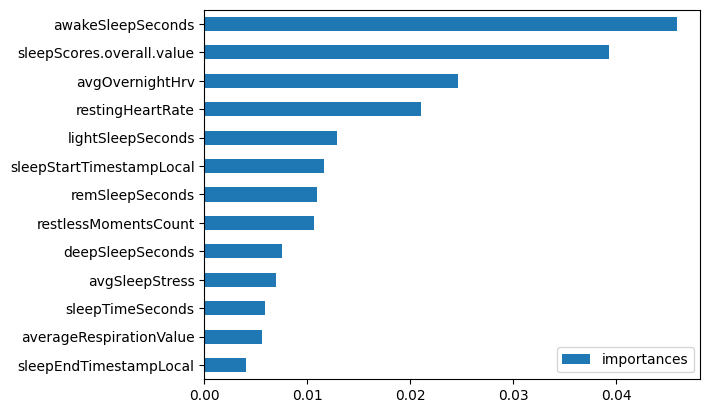

In [59]:
import matplotlib.pyplot as plt
feature_df.sort_values(by="importances",ascending=True).plot.barh()
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
# Die Indizes der Merkmale in absteigender Wichtigkeit sortieren
indices = np.argsort(importances)[::-1]

# Die Namen der sortierten Merkmale
names = [features.columns[i] for i in indices]

# Ein Barplot erstellen
plt.figure(figsize=(10, 5))
plt.title("Merkmalswichtigkeiten")
plt.bar(range(features.shape[1]), importances[indices])
plt.xticks(range(features.shape[1]), names, rotation=45)
plt.show()

NameError: name 'plt' is not defined

Classification without One-Hot - Class Weights

In [73]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

data_copy = data.copy().dropna()

# list of columns that need to be dropped
to_drop = ['temp_id', 'id', 'calendarDate', 'ageGroup',
            'ausgeschlafen', 'motivation', 'Wach', 'konzentriert',
            'Test_zeit', 'Test_anzahl','prozent_zeit_rang', 'prozent_anzahl'] 

# train with the suitable dataset
features = data_copy.drop(to_drop, axis=1)  # Drop the target variable to isolate the features
target = data_copy['konzentriert']#.to_numpy() # Isolate the target variable

# Convert Timestamp to Unix format
features['sleepStartTimestampLocal'] = features['sleepStartTimestampLocal'].astype('int64') // 10**9
 
features['sleepEndTimestampLocal'] = features['sleepEndTimestampLocal'].astype('int64') // 10**9

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# normalize the features values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train size : {X_train.shape}\ny_train size : {y_train.shape}")

X_train size : (57, 2031)
y_train size : (57,)


In [75]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary to map class indices to their respective weights
class_weight = dict(zip(np.unique(y_train), class_weights))

class_weight

{2: 2.85, 3: 0.6785714285714286, 4: 0.7916666666666666, 5: 1.0961538461538463}

In [76]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, criterion = 'entropy', class_weight=class_weight)

parameters = {"n_estimators" : [20, 40, 60, 80],
              "max_depth": [5, 8, 10, 12, 15],
              "min_samples_leaf": [2, 4, 6, 8, 10],
              "n_estimators":[10, 50, 100]}
 
random_search = RandomizedSearchCV(rf_classifier, parameters, n_iter=20, verbose=2)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=12, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=8, n_estimators=100; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=8, n_estimators=100; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=8, n_estimators=100; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=8, n_estimators=100; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=8, n_estimators=100; total time=   0.0s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=5, min_samples_leaf=2, n_e

RandomizedSearchCV(estimator=RandomForestClassifier(class_weight={2: 2.85,
                                                                  3: 0.6785714285714286,
                                                                  4: 0.7916666666666666,
                                                                  5: 1.0961538461538463},
                                                    criterion='entropy',
                                                    random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [5, 8, 10, 12, 15],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 50, 100]},
                   verbose=2)

In [77]:
best_model = random_search.best_estimator_
# Train the regressor
best_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={2: 2.85, 3: 0.6785714285714286,
                                     4: 0.7916666666666666,
                                     5: 1.0961538461538463},
                       criterion='entropy', max_depth=10, min_samples_leaf=6,
                       random_state=42)

In [78]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred = best_model.predict(X_test)
 
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate accuracy
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse * 100:.2f}%")

Accuracy: 26.67%
MSE: 133.33%
